In [2]:
import numpy as np

class Environment(object):
    """
    Server Temperature Control Environment

    This environment simulates a server cooling system where:
    - AI can take actions to cool down or heat up the server
    - The goal is to maintain optimal temperature while minimizing energy consumption
    - External factors like atmospheric temperature, number of users, and data rate affect the server temperature
    """

    def __init__(self, optimal_temperature=[18.0, 24.0], initial_month=0,
                 initial_number_users=10, initial_rate_data=60):
        """
        Initialize the environment

        Parameters:
        - optimal_temperature: [min_optimal, max_optimal] temperature range in Celsius
        - initial_month: starting month (0-11, where 0=January)
        - initial_number_users: initial number of users on the server
        - initial_rate_data: initial data processing rate
        """

        # === TEMPORAL PARAMETERS ===
        self.initial_month = initial_month

        # Monthly atmospheric temperatures (January to December)
        self.monthly_atmospheric_temperatures = [1.0, 5.0, 7.0, 10.0, 11.0, 20.0,
                                                23.0, 24.0, 22.0, 10.0, 5.0, 1.0]
        self.atmospheric_temperature = self.monthly_atmospheric_temperatures[initial_month]

        # === TEMPERATURE PARAMETERS ===
        self.optimal_temperature = optimal_temperature  # Target temperature range
        self.min_temperature = -20  # Absolute minimum (causes game over if reached)
        self.max_temperature = 80   # Absolute maximum (causes game over if reached)

        # === USER PARAMETERS ===
        self.min_number_users = 10
        self.max_number_users = 100
        self.max_update_users = 5   # Maximum change in users per step
        self.initial_number_users = initial_number_users
        self.current_number_users = initial_number_users

        # === DATA RATE PARAMETERS ===
        self.min_rate_data = 20
        self.max_rate_data = 300
        self.max_update_data = 10   # Maximum change in data rate per step
        self.initial_rate_data = initial_rate_data
        self.current_rate_data = initial_rate_data

        # === TEMPERATURE CALCULATIONS ===
        # Intrinsic temperature = atmospheric + heat from users + heat from data processing
        self.intrinsic_temperature = (self.atmospheric_temperature +
                                    1.25 * self.current_number_users +
                                    1.25 * self.current_rate_data)

        # Server temperature with AI control
        self.temperature_ai = self.intrinsic_temperature

        # Server temperature without AI (baseline - starts at middle of optimal range)
        self.temperature_noai = (self.optimal_temperature[0] + self.optimal_temperature[1]) / 2.0

        # === ENERGY TRACKING ===
        self.total_energy_ai = 0.0      # Total energy consumed by AI system
        self.total_energy_noai = 0.0    # Total energy consumed by non-AI system

        # === GAME STATE ===
        self.reward = 0.0
        self.game_over = 0
        self.train = 1  # 1 for training mode, 0 for inference mode

    def update_env(self, direction, energy_ai, month):
        """
        Update the environment after AI takes an action

        Parameters:
        - direction: +1 (heating) or -1 (cooling)
        - energy_ai: amount of energy the AI uses for the action
        - month: current month (0-11)

        Returns:
        - next_state: normalized state vector for neural network
        - reward: reward for the action taken
        - game_over: whether the episode should end
        """

        # === STEP 1: CALCULATE REWARD ===
        # First, simulate what a non-AI system would do
        energy_noai = 0
        if self.temperature_noai < self.optimal_temperature[0]:
            # Too cold - need to heat up
            energy_noai = self.optimal_temperature[0] - self.temperature_noai
            self.temperature_noai = self.optimal_temperature[0]
        elif self.temperature_noai > self.optimal_temperature[1]:
            # Too hot - need to cool down
            energy_noai = self.temperature_noai - self.optimal_temperature[1]
            self.temperature_noai = self.optimal_temperature[1]

        # Reward = energy saved compared to non-AI system
        self.reward = energy_noai - energy_ai
        self.reward = 1e-3 * self.reward  # Scale reward

        # === STEP 2: UPDATE ENVIRONMENTAL FACTORS ===
        # Update atmospheric temperature based on month
        self.atmospheric_temperature = self.monthly_atmospheric_temperatures[month]

        # Randomly update number of users (simulates varying server load)
        self.current_number_users += np.random.randint(-self.max_update_users, self.max_update_users)
        self.current_number_users = np.clip(self.current_number_users,
                                          self.min_number_users, self.max_number_users)

        # Randomly update data processing rate
        self.current_rate_data += np.random.randint(-self.max_update_data, self.max_update_data)
        self.current_rate_data = np.clip(self.current_rate_data,
                                       self.min_rate_data, self.max_rate_data)

        # === STEP 3: UPDATE TEMPERATURES ===
        # Calculate change in intrinsic temperature
        past_intrinsic_temperature = self.intrinsic_temperature
        self.intrinsic_temperature = (self.atmospheric_temperature +
                                    1.25 * self.current_number_users +
                                    1.25 * self.current_rate_data)
        delta_intrinsic_temperature = self.intrinsic_temperature - past_intrinsic_temperature

        # Calculate temperature change from AI action
        if direction == -1:
            delta_temperature_ai = -energy_ai  # Cooling
        elif direction == 1:
            delta_temperature_ai = energy_ai   # Heating

        # Update AI-controlled temperature
        self.temperature_ai += delta_intrinsic_temperature + delta_temperature_ai

        # Update non-AI temperature (only affected by environmental changes)
        self.temperature_noai += delta_intrinsic_temperature

        # === STEP 4: CHECK GAME OVER CONDITIONS ===
        if self.temperature_ai < self.min_temperature:
            if self.train == 1:
                self.game_over = 1  # End episode during training
            else:
                # During inference, apply corrective energy cost
                self.total_energy_ai += self.optimal_temperature[0] - self.temperature_ai
                self.temperature_ai = self.optimal_temperature[0]
        elif self.temperature_ai > self.max_temperature:
            if self.train == 1:
                self.game_over = 1  # End episode during training
            else:
                # During inference, apply corrective energy cost
                self.total_energy_ai += self.temperature_ai - self.optimal_temperature[1]
                self.temperature_ai = self.optimal_temperature[1]

        # === STEP 5: UPDATE ENERGY TOTALS ===
        self.total_energy_ai += energy_ai
        self.total_energy_noai += energy_noai

        # === STEP 6: CREATE NORMALIZED STATE VECTOR ===
        # Normalize all values to [0, 1] range for neural network input
        scaled_temperature_ai = ((self.temperature_ai - self.min_temperature) /
                               (self.max_temperature - self.min_temperature))
        scaled_number_users = ((self.current_number_users - self.min_number_users) /
                             (self.max_number_users - self.min_number_users))
        scaled_rate_data = ((self.current_rate_data - self.min_rate_data) /
                          (self.max_rate_data - self.min_rate_data))

        next_state = np.matrix([scaled_temperature_ai, scaled_number_users, scaled_rate_data])

        return next_state, self.reward, self.game_over

    def reset(self, new_month):
        """
        Reset the environment to initial state for a new episode

        Parameters:
        - new_month: starting month for the new episode (0-11)
        """
        self.atmospheric_temperature = self.monthly_atmospheric_temperatures[new_month]
        self.initial_month = new_month
        self.current_number_users = self.initial_number_users
        self.current_rate_data = self.initial_rate_data

        # Recalculate intrinsic temperature
        self.intrinsic_temperature = (self.atmospheric_temperature +
                                    1.25 * self.current_number_users +
                                    1.25 * self.current_rate_data)

        # Reset temperatures
        self.temperature_ai = self.intrinsic_temperature
        self.temperature_noai = (self.optimal_temperature[0] + self.optimal_temperature[1]) / 2.0

        # Reset tracking variables
        self.total_energy_ai = 0.0
        self.total_energy_noai = 0.0
        self.reward = 0.0
        self.game_over = 0
        self.train = 1

    def observe(self):
        """
        Get the current state of the environment

        Returns:
        - current_state: normalized state vector [temperature, users, data_rate]
        - reward: last reward received
        - game_over: whether the episode has ended
        """
        # Normalize current state
        scaled_temperature_ai = ((self.temperature_ai - self.min_temperature) /
                               (self.max_temperature - self.min_temperature))
        scaled_number_users = ((self.current_number_users - self.min_number_users) /
                             (self.max_number_users - self.min_number_users))
        scaled_rate_data = ((self.current_rate_data - self.min_rate_data) /
                          (self.max_rate_data - self.min_rate_data))

        current_state = np.matrix([scaled_temperature_ai, scaled_number_users, scaled_rate_data])

        return current_state, self.reward, self.game_over


# Environment Class Documentation

## Overview

The `Environment` class simulates a **server temperature control system** for reinforcement learning applications. It models a realistic scenario where an AI agent must maintain optimal server temperature while minimizing energy consumption, accounting for external factors like atmospheric temperature, user load, and data processing rates.

## Key Features

- **Realistic Temperature Simulation**: Models atmospheric temperature variations throughout the year
- **Dynamic Server Load**: Simulates changing user numbers and data processing rates
- **Energy Optimization**: Rewards energy-efficient temperature control
- **Training/Inference Modes**: Different behaviors for training and deployment
- **Normalized State Space**: Outputs ready for neural network consumption

---

## Class Constructor

### `__init__(self, optimal_temperature=[18.0, 24.0], initial_month=0, initial_number_users=10, initial_rate_data=60)`

Initializes the server temperature control environment.

**Parameters:**
- `optimal_temperature` (list): Target temperature range [min_temp, max_temp] in Celsius
- `initial_month` (int): Starting month (0-11, where 0=January)
- `initial_number_users` (int): Initial number of users on the server
- `initial_rate_data` (int): Initial data processing rate

**Example:**
```python
# Create environment with custom parameters
env = Environment(
    optimal_temperature=[20.0, 25.0],  # Optimal range: 20-25°C
    initial_month=5,                   # Start in June
    initial_number_users=50,           # 50 initial users
    initial_rate_data=100              # Data rate of 100
)
```

---

## Core Methods

### `update_env(self, direction, energy_ai, month)`

Updates the environment state after an AI action is taken.

**Parameters:**
- `direction` (int): Action direction (+1 for heating, -1 for cooling)
- `energy_ai` (float): Amount of energy the AI uses for the action
- `month` (int): Current month (0-11)

**Returns:**
- `next_state` (numpy.matrix): Normalized state vector [temperature, users, data_rate]
- `reward` (float): Reward for the action (energy saved vs baseline)
- `game_over` (int): 1 if episode should end, 0 otherwise

**Example:**
```python
# AI decides to cool down the server using 2.5 units of energy in July
next_state, reward, done = env.update_env(
    direction=-1,    # Cooling action
    energy_ai=2.5,   # Energy consumption
    month=6          # July (0-indexed)
)

print(f"Next state: {next_state}")
print(f"Reward: {reward}")
print(f"Episode finished: {done}")
```

### `reset(self, new_month)`

Resets the environment to initial conditions for a new episode.

**Parameters:**
- `new_month` (int): Starting month for the new episode (0-11)

**Example:**
```python
# Reset environment to start a new episode in December
env.reset(new_month=11)
print(f"Environment reset to month {env.initial_month}")
```

### `observe(self)`

Returns the current state of the environment without making any changes.

**Returns:**
- `current_state` (numpy.matrix): Normalized current state
- `reward` (float): Last reward received
- `game_over` (int): Current game over status

**Example:**
```python
# Observe current environment state
state, reward, done = env.observe()
print(f"Current temperature (scaled): {state[0,0]:.3f}")
print(f"Current users (scaled): {state[0,1]:.3f}")
print(f"Current data rate (scaled): {state[0,2]:.3f}")
```

---

## Environment Dynamics

### Temperature Calculation

The server temperature is influenced by three factors:

1. **Atmospheric Temperature**: Varies monthly (1°C in January to 24°C in August)
2. **User Load**: Each user contributes 1.25°C to server heat
3. **Data Processing**: Each unit of data rate contributes 1.25°C

**Formula:**
```
intrinsic_temperature = atmospheric_temp + 1.25 * users + 1.25 * data_rate
```

### Reward System

The reward encourages energy efficiency by comparing AI performance to a baseline system:

```
reward = (energy_used_by_baseline - energy_used_by_ai) * 0.001
```

### Game Over Conditions

During training, the episode ends if temperature goes outside safe limits:
- **Too Cold**: Below -20°C
- **Too Hot**: Above 80°C

During inference, corrective energy costs are applied instead.

---

## Complete Usage Example

```python
import numpy as np

# Initialize environment
env = Environment(
    optimal_temperature=[18.0, 24.0],
    initial_month=0,
    initial_number_users=20,
    initial_rate_data=80
)

# Training loop example
for episode in range(5):
    # Reset for new episode
    env.reset(new_month=episode % 12)
    
    # Get initial state
    state, reward, done = env.observe()
    print(f"\nEpisode {episode + 1} - Initial state:")
    print(f"  Temperature: {state[0,0]:.3f} (scaled)")
    print(f"  Users: {state[0,1]:.3f} (scaled)")
    print(f"  Data rate: {state[0,2]:.3f} (scaled)")
    
    # Simulate some actions
    for step in range(3):
        # Simple policy: cool if temperature > 0.6, heat if < 0.4
        if state[0,0] > 0.6:
            action_direction = -1  # Cool
            energy_used = 2.0
        elif state[0,0] < 0.4:
            action_direction = 1   # Heat
            energy_used = 2.0
        else:
            action_direction = 0   # No action
            energy_used = 0.0
        
        # Only update if action is taken
        if action_direction != 0:
            state, reward, done = env.update_env(
                direction=action_direction,
                energy_ai=energy_used,
                month=(episode + step) % 12
            )
            
            print(f"  Step {step + 1}: Action={action_direction}, Energy={energy_used}, Reward={reward:.4f}")
            
            if done:
                print(f"  Episode ended early!")
                break
        else:
            print(f"  Step {step + 1}: No action taken")
    
    print(f"  Total AI energy: {env.total_energy_ai:.2f}")
    print(f"  Total baseline energy: {env.total_energy_noai:.2f}")
```

---

## Key Attributes

### Temperature Parameters
- `optimal_temperature`: Target temperature range [min, max]
- `min_temperature`: Absolute minimum (-20°C)
- `max_temperature`: Absolute maximum (80°C)
- `temperature_ai`: Current AI-controlled temperature
- `temperature_noai`: Current baseline system temperature

### Environmental Factors
- `atmospheric_temperature`: Current atmospheric temperature
- `current_number_users`: Current number of users (10-100)
- `current_rate_data`: Current data processing rate (20-300)

### Energy Tracking
- `total_energy_ai`: Total energy consumed by AI system
- `total_energy_noai`: Total energy consumed by baseline system

### State Variables
- `reward`: Last reward received
- `game_over`: Episode termination flag
- `train`: Training mode flag (1=training, 0=inference)

---

## Tips for Colab Usage

1. **Import Dependencies**: Make sure to import numpy at the beginning of your notebook
2. **Visualization**: Consider plotting temperature and energy consumption over time
3. **Parameter Tuning**: Experiment with different optimal temperature ranges
4. **Seasonal Effects**: Try running episodes across different months to see seasonal impacts
5. **Energy Analysis**: Compare AI vs baseline energy consumption for performance evaluation

```python
# Essential imports for Colab
import numpy as np
import matplotlib.pyplot as plt

# Optional: For better visualization
import seaborn as sns
sns.set_style("whitegrid")
```

In [3]:

if __name__ == "__main__":
    print("=== SERVER COOLING ENVIRONMENT DEMONSTRATION ===\n")

    # Create environment starting in January (month 0)
    env = Environment(optimal_temperature=[18.0, 24.0], initial_month=0,
                     initial_number_users=20, initial_rate_data=80)

    print("1. INITIAL STATE:")
    print(f"   Atmospheric temperature: {env.atmospheric_temperature}°C")
    print(f"   Number of users: {env.current_number_users}")
    print(f"   Data rate: {env.current_rate_data}")
    print(f"   Intrinsic temperature: {env.intrinsic_temperature:.2f}°C")
    print(f"   AI temperature: {env.temperature_ai:.2f}°C")
    print(f"   No-AI temperature: {env.temperature_noai:.2f}°C")
    print(f"   Optimal range: {env.optimal_temperature[0]}-{env.optimal_temperature[1]}°C")

    # Get initial observation
    state, reward, game_over = env.observe()
    print(f"\n2. INITIAL OBSERVATION:")
    print(f"   Normalized state: {state}")
    print(f"   Reward: {reward}")
    print(f"   Game over: {game_over}")

    print(f"\n3. TAKING ACTIONS:")

    # Example 1: AI tries to cool down the server
    print(f"\n   ACTION 1: Cool down (direction=-1, energy=2.0)")
    print(f"   Before action - AI temp: {env.temperature_ai:.2f}°C")

    next_state, reward, game_over = env.update_env(direction=-1, energy_ai=2.0, month=0)

    print(f"   After action - AI temp: {env.temperature_ai:.2f}°C")
    print(f"   Reward: {reward:.6f}")
    print(f"   New state: {next_state}")
    print(f"   Game over: {game_over}")

    # Example 2: AI tries to heat up the server
    print(f"\n   ACTION 2: Heat up (direction=+1, energy=1.5)")
    print(f"   Before action - AI temp: {env.temperature_ai:.2f}°C")

    next_state, reward, game_over = env.update_env(direction=1, energy_ai=1.5, month=1)

    print(f"   After action - AI temp: {env.temperature_ai:.2f}°C")
    print(f"   Reward: {reward:.6f}")
    print(f"   New state: {next_state}")
    print(f"   Game over: {game_over}")

    # Show how environmental factors changed
    print(f"\n4. ENVIRONMENTAL CHANGES:")
    print(f"   Atmospheric temp: {env.atmospheric_temperature}°C (changed to February)")
    print(f"   Number of users: {env.current_number_users} (randomly updated)")
    print(f"   Data rate: {env.current_rate_data} (randomly updated)")
    print(f"   Total energy - AI: {env.total_energy_ai:.2f}")
    print(f"   Total energy - No AI: {env.total_energy_noai:.2f}")

    # Reset environment
    print(f"\n5. RESETTING ENVIRONMENT:")
    env.reset(new_month=6)  # Reset to July
    state, reward, game_over = env.observe()
    print(f"   Reset to July - Atmospheric temp: {env.atmospheric_temperature}°C")
    print(f"   AI temperature: {env.temperature_ai:.2f}°C")
    print(f"   Reset state: {state}")

    print(f"\n=== END OF DEMONSTRATION ===")

=== SERVER COOLING ENVIRONMENT DEMONSTRATION ===

1. INITIAL STATE:
   Atmospheric temperature: 1.0°C
   Number of users: 20
   Data rate: 80
   Intrinsic temperature: 126.00°C
   AI temperature: 126.00°C
   No-AI temperature: 21.00°C
   Optimal range: 18.0-24.0°C

2. INITIAL OBSERVATION:
   Normalized state: [[1.46       0.11111111 0.21428571]]
   Reward: 0.0
   Game over: 0

3. TAKING ACTIONS:

   ACTION 1: Cool down (direction=-1, energy=2.0)
   Before action - AI temp: 126.00°C
   After action - AI temp: 121.50°C
   Reward: -0.002000
   New state: [[1.415      0.14444444 0.19642857]]
   Game over: 1

   ACTION 2: Heat up (direction=+1, energy=1.5)
   Before action - AI temp: 121.50°C
   After action - AI temp: 117.00°C
   Reward: -0.001500
   New state: [[1.37       0.13333333 0.17142857]]
   Game over: 1

4. ENVIRONMENTAL CHANGES:
   Atmospheric temp: 5.0°C (changed to February)
   Number of users: 22 (randomly updated)
   Data rate: 68 (randomly updated)
   Total energy - AI: 3.5

In [5]:

import numpy as np

# Initialize environment
env = Environment(
    optimal_temperature=[18.0, 24.0],
    initial_month=0,
    initial_number_users=10,
    initial_rate_data=20
)

# Training loop example
for episode in range(5):
    # Reset for new episode
    env.reset(new_month=episode % 12)

    # Get initial state
    state, reward, done = env.observe()
    print(f"\nEpisode {episode + 1} - Initial state:")
    print(f"  Temperature: {state[0,0]:.3f} (scaled)")
    print(f"  Users: {state[0,1]:.3f} (scaled)")
    print(f"  Data rate: {state[0,2]:.3f} (scaled)")

    # Simulate some actions
    for step in range(3):
        # Simple policy: cool if temperature > 0.6, heat if < 0.4
        if state[0,0] > 0.6:
            action_direction = -1  # Cool
            energy_used = 2.0
        elif state[0,0] < 0.4:
            action_direction = 1   # Heat
            energy_used = 2.0
        else:
            action_direction = 0   # No action
            energy_used = 0.0

        # Only update if action is taken
        if action_direction != 0:
            state, reward, done = env.update_env(
                direction=action_direction,
                energy_ai=energy_used,
                month=(episode + step) % 12
            )

            print(f"  Step {step + 1}: Action={action_direction}, Energy={energy_used}, Reward={reward:.4f}")

            if done:
                print(f"  Episode ended early!")
                break
        else:
            print(f"  Step {step + 1}: No action taken")

    print(f"  Total AI energy: {env.total_energy_ai:.2f}")
    print(f"  Total baseline energy: {env.total_energy_noai:.2f}")


Episode 1 - Initial state:
  Temperature: 0.585 (scaled)
  Users: 0.000 (scaled)
  Data rate: 0.000 (scaled)
  Step 1: No action taken
  Step 2: No action taken
  Step 3: No action taken
  Total AI energy: 0.00
  Total baseline energy: 0.00

Episode 2 - Initial state:
  Temperature: 0.625 (scaled)
  Users: 0.000 (scaled)
  Data rate: 0.000 (scaled)
  Step 1: Action=-1, Energy=2.0, Reward=-0.0020
  Step 2: Action=-1, Energy=2.0, Reward=-0.0020
  Step 3: Action=-1, Energy=2.0, Reward=0.0045
  Total AI energy: 6.00
  Total baseline energy: 6.50

Episode 3 - Initial state:
  Temperature: 0.645 (scaled)
  Users: 0.000 (scaled)
  Data rate: 0.000 (scaled)
  Step 1: Action=-1, Energy=2.0, Reward=-0.0020
  Step 2: Action=-1, Energy=2.0, Reward=0.0100
  Step 3: Action=-1, Energy=2.0, Reward=0.0085
  Total AI energy: 6.00
  Total baseline energy: 22.50

Episode 4 - Initial state:
  Temperature: 0.675 (scaled)
  Users: 0.000 (scaled)
  Data rate: 0.000 (scaled)
  Step 1: Action=-1, Energy=2.0, R

In [6]:
# Take an action: cool down with 2.0 energy units
next_state, reward, done = env.update_env(
    direction=-1,    # -1 for cooling, +1 for heating
    energy_ai=10.0,   # Energy consumed by AI
    month=0          # Current month
)

print(f"Reward: {reward:.6f}")
print(f"New temperature: {env.temperature_ai:.2f}°C")
print(f"Episode done: {done}")

Reward: -0.005750
New temperature: 27.50°C
Episode done: 0


SIMPLE TEMPERATURE CONTROL DEMONSTRATION
This demo shows how heating and cooling actions affect temperature
We'll cycle through different actions to see the direct effects
=== SIMPLE UP/DOWN TEMPERATURE TEST ===

Initial temperature: 26.00°C
Optimal range: 18.0-24.0°C

Starting temperature control cycle...

Step  0: Current Temp= 26.00°C, Users=10, Data= 10, Atm= 1.00°C, Action=Heat up (dir=+1, energy=1.0)
         After action: New Temp= 42.00°C, Change=+16.00°C, Reward=-0.001000

Step  1: Current Temp= 42.00°C, Users=12, Data= 20, Atm= 1.00°C, Action=Heat up (dir=+1, energy=1.0)
         After action: New Temp= 44.50°C, Change= +2.50°C, Reward=0.011000

Step  2: Current Temp= 44.50°C, Users=10, Data= 20, Atm= 5.00°C, Action=Cool down (dir=-1, energy=1.0)
         After action: New Temp= 46.75°C, Change= +2.25°C, Reward=0.000500

Step  3: Current Temp= 46.75°C, Users=11, Data= 20, Atm= 7.00°C, Action=Cool down (dir=-1, energy=1.0)
         After action: New Temp= 63.75°C, Change=+17.0

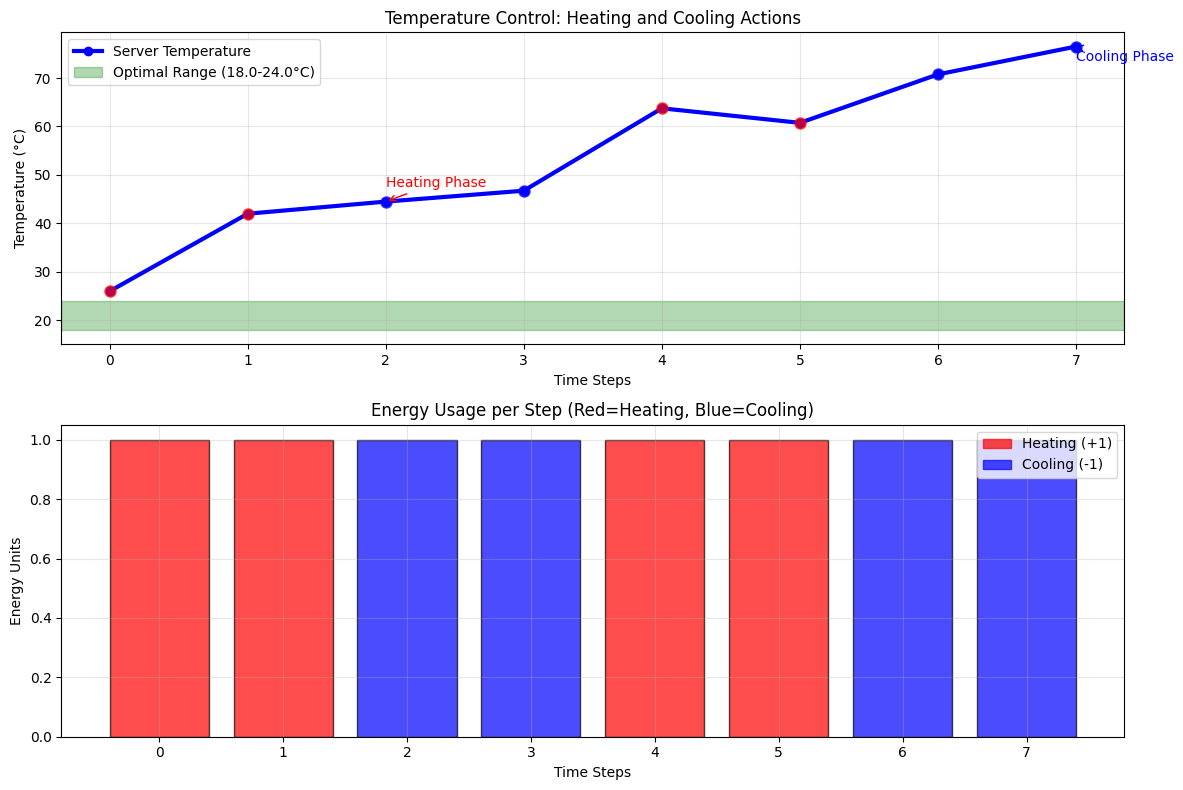


=== ACTION SUMMARY ===
Heating actions: 4
Cooling actions: 4
Total actions: 8

DEMO COMPLETED SUCCESSFULLY!
Temperature changed from 26.00°C to 76.50°C
Maximum temperature reached: 76.50°C
Minimum temperature reached: 26.00°C
Total energy used: 8.00
Check the plot window to see the temperature changes!


In [16]:
"""
Simple Temperature Control Test

This script demonstrates basic temperature control using the Environment class.
We'll use a simple for loop to repeatedly heat and cool the server temperature
to show how actions directly affect temperature.

Author: Your Name
Date: 2025
"""

import numpy as np
import matplotlib.pyplot as plt

def simple_up_down_temperature_test():
    """
    Simple test that cycles temperature up and down to demonstrate basic control
    """

    print("=== SIMPLE UP/DOWN TEMPERATURE TEST ===\n")

    # Create environment
    env = Environment(
        optimal_temperature=[18.0, 24.0],
        initial_month=0,  # January
        initial_number_users=10,
        initial_rate_data=10
    )

    # Reset environment
    env.reset(0)

    # Get initial state
    current_state, reward, game_over = env.observe()

    print(f"Initial temperature: {env.temperature_ai:.2f}°C")
    print(f"Optimal range: {env.optimal_temperature[0]}-{env.optimal_temperature[1]}°C")
    print("\nStarting temperature control cycle...\n")

    # Data collection for plotting
    temperatures = []
    actions_taken = []
    rewards = []
    steps = []
    energy_used = []
    directions = []

    # Simple control cycle: start with small actions to see what's happening
    num_steps = 20

    for step in range(num_steps):
        current_temp = env.temperature_ai

        # Record current state BEFORE action
        temperatures.append(current_temp)
        steps.append(step)

        # Very simple pattern: alternate between heating and cooling
        if step % 4 < 2:
            # Heat up for 2 steps, then cool for 2 steps
            direction = 1  # Heat up
            energy = 1.0   # Small energy amount
            action_desc = "Heat up"
        else:
            direction = -1  # Cool down
            energy = 1.0   # Small energy amount
            action_desc = "Cool down"

        # Record action
        actions_taken.append(action_desc)
        energy_used.append(energy)
        directions.append(direction)

        # Print BEFORE taking action
        print(f"Step {step:2d}: Current Temp={current_temp:6.2f}°C, "
              f"Users={env.current_number_users:2d}, "
              f"Data={env.current_rate_data:3d}, "
              f"Atm={env.atmospheric_temperature:5.2f}°C, "
              f"Action={action_desc} (dir={direction:+2d}, energy={energy:.1f})")

        # Take action
        try:
            next_state, reward, game_over = env.update_env(direction, energy, step % 12)
            rewards.append(reward)

            # Print AFTER taking action to see the change
            print(f"         After action: New Temp={env.temperature_ai:6.2f}°C, "
                  f"Change={env.temperature_ai - current_temp:+6.2f}°C, "
                  f"Reward={reward:.6f}")

            # Check if temperature actually changed
            if abs(env.temperature_ai - current_temp) < 0.01:
                print(f"         ⚠️  WARNING: Temperature barely changed! "
                      f"Intrinsic temp={env.intrinsic_temperature:.2f}°C")

            if game_over:
                print(f"\n⚠️  Episode terminated at step {step}")
                print(f"Final temperature: {env.temperature_ai:.2f}°C")
                print(f"Temperature bounds: [{env.min_temperature}, {env.max_temperature}]")
                break

        except Exception as e:
            print(f"Error at step {step}: {e}")
            break

        print()  # Empty line for readability

    # Final statistics
    print(f"\n=== FINAL RESULTS ===")
    print(f"Steps completed: {len(temperatures)}")
    print(f"Initial temperature: {temperatures[0]:.2f}°C")
    print(f"Final temperature: {temperatures[-1]:.2f}°C")
    print(f"Temperature range: {min(temperatures):.2f}°C to {max(temperatures):.2f}°C")
    print(f"Total energy used by AI: {env.total_energy_ai:.2f}")
    print(f"Total energy used by baseline: {env.total_energy_noai:.2f}")
    print(f"Energy difference: {env.total_energy_noai - env.total_energy_ai:.2f}")
    print(f"Average reward: {np.mean(rewards):.6f}")

    # Also add some debugging info
    print(f"Debug: len(temperatures)={len(temperatures)}, len(steps)={len(steps)}")
    print(f"Debug: len(directions)={len(directions)}, len(energy_used)={len(energy_used)}")

    # Only create plot if we have data
    if len(temperatures) == 0:
        print("No temperature data to plot!")
        return

    # Create and show plot
    create_simple_plot(steps, temperatures, actions_taken, energy_used, directions, env.optimal_temperature)

    return temperatures, actions_taken, rewards, energy_used

def create_simple_plot(steps, temperatures, actions, energy_used, directions, optimal_range):
    """Create a simple plot showing temperature changes"""

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Plot 1: Temperature over time
    ax1.plot(steps, temperatures, 'b-', linewidth=3, marker='o', markersize=6, label='Server Temperature')

    # Show optimal range
    ax1.axhspan(optimal_range[0], optimal_range[1], alpha=0.3, color='green',
                label=f'Optimal Range ({optimal_range[0]}-{optimal_range[1]}°C)')

    # Add markers for heating/cooling actions (only if we have data)
    for i, (temp, direction) in enumerate(zip(temperatures, directions)):
        if i < len(temperatures):  # Safety check
            if direction == 1:  # Heating
                ax1.plot(i, temp, 'ro', markersize=8, alpha=0.7)
            else:  # Cooling
                ax1.plot(i, temp, 'bo', markersize=8, alpha=0.7)

    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel('Temperature (°C)')
    ax1.set_title('Temperature Control: Heating and Cooling Actions')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add annotations to show what's happening (only if we have enough data)
    if len(temperatures) > 2:
        ax1.annotate('Heating Phase', xy=(2, temperatures[2]), xytext=(2, temperatures[2] + 3),
                    arrowprops=dict(arrowstyle='->', color='red'), fontsize=10, color='red')
    if len(temperatures) > 7:
        ax1.annotate('Cooling Phase', xy=(7, temperatures[7]), xytext=(7, temperatures[7] - 3),
                    arrowprops=dict(arrowstyle='->', color='blue'), fontsize=10, color='blue')

    # Plot 2: Energy usage with direction colors
    colors = ['red' if d == 1 else 'blue' for d in directions]
    bars = ax2.bar(steps, energy_used, color=colors, alpha=0.7, edgecolor='black', linewidth=1)

    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Energy Units')
    ax2.set_title('Energy Usage per Step (Red=Heating, Blue=Cooling)')
    ax2.grid(True, alpha=0.3)

    # Add legend for colors
    import matplotlib.patches as mpatches
    red_patch = mpatches.Patch(color='red', alpha=0.7, label='Heating (+1)')
    blue_patch = mpatches.Patch(color='blue', alpha=0.7, label='Cooling (-1)')
    ax2.legend(handles=[red_patch, blue_patch])

    # Adjust layout and show
    plt.tight_layout()
    plt.show()

    # Print action summary
    print(f"\n=== ACTION SUMMARY ===")
    heating_count = sum(1 for d in directions if d == 1)
    cooling_count = sum(1 for d in directions if d == -1)
    print(f"Heating actions: {heating_count}")
    print(f"Cooling actions: {cooling_count}")
    print(f"Total actions: {len(directions)}")

def run_simple_demo():
    """
    Run the simple demonstration
    """
    print("="*60)
    print("SIMPLE TEMPERATURE CONTROL DEMONSTRATION")
    print("="*60)
    print("This demo shows how heating and cooling actions affect temperature")
    print("We'll cycle through different actions to see the direct effects")
    print("="*60)

    try:
        temperatures, actions, rewards, energy = simple_up_down_temperature_test()

        print("\n" + "="*60)
        print("DEMO COMPLETED SUCCESSFULLY!")
        print("="*60)
        print(f"Temperature changed from {temperatures[0]:.2f}°C to {temperatures[-1]:.2f}°C")
        print(f"Maximum temperature reached: {max(temperatures):.2f}°C")
        print(f"Minimum temperature reached: {min(temperatures):.2f}°C")
        print(f"Total energy used: {sum(energy):.2f}")
        print("Check the plot window to see the temperature changes!")

    except Exception as e:
        print(f"Demo failed with error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    run_simple_demo()

Streaming output truncated to the last 5000 lines.
    Q-update: reward=0.0023, γ*max_Q(s')=0.0297
    Q((9, 0, 0),0): 0.0281 → 0.0285 (TD_error: 0.0038)
    Q-update: reward=-0.0020, γ*max_Q(s')=0.0276
    Q((6, 0, 0),2): 0.0303 → 0.0298 (TD_error: -0.0047)
    Q-update: reward=-0.0020, γ*max_Q(s')=0.0283
    Q((7, 0, 0),0): 0.0290 → 0.0287 (TD_error: -0.0027)
    Q-update: reward=-0.0020, γ*max_Q(s')=0.0297
    Q((6, 0, 0),2): 0.0298 → 0.0296 (TD_error: -0.0021)
    Q-update: reward=0.0155, γ*max_Q(s')=0.0297
    Q((8, 0, 0),2): 0.0296 → 0.0311 (TD_error: 0.0157)
    Q-update: reward=0.0000, γ*max_Q(s')=0.0297
    Q((8, 0, 0),1): 0.0283 → 0.0284 (TD_error: 0.0014)
    Q-update: reward=0.0000, γ*max_Q(s')=0.0297
    Q((8, 0, 0),2): 0.0311 → 0.0310 (TD_error: -0.0014)
    Q-update: reward=-0.0020, γ*max_Q(s')=0.0273
    Q((8, 0, 0),0): 0.0313 → 0.0307 (TD_error: -0.0060)
    Q-update: reward=0.0110, γ*max_Q(s')=0.0281
    Q((7, 0, 0),0): 0.0287 → 0.0298 (TD_error: 0.0104)
    Q-update:

/tmp/ipython-input-15-2475628471.py:616: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-15-2475628471.py:616: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-15-2475628471.py:616: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-15-2475628471.py:616: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-15-2475628471.py:616: UserWarning: Glyph 9208 (\N{DOUBLE VERTICAL BAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-15-2475628471.py:616: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-15-2475628471.py:616: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11

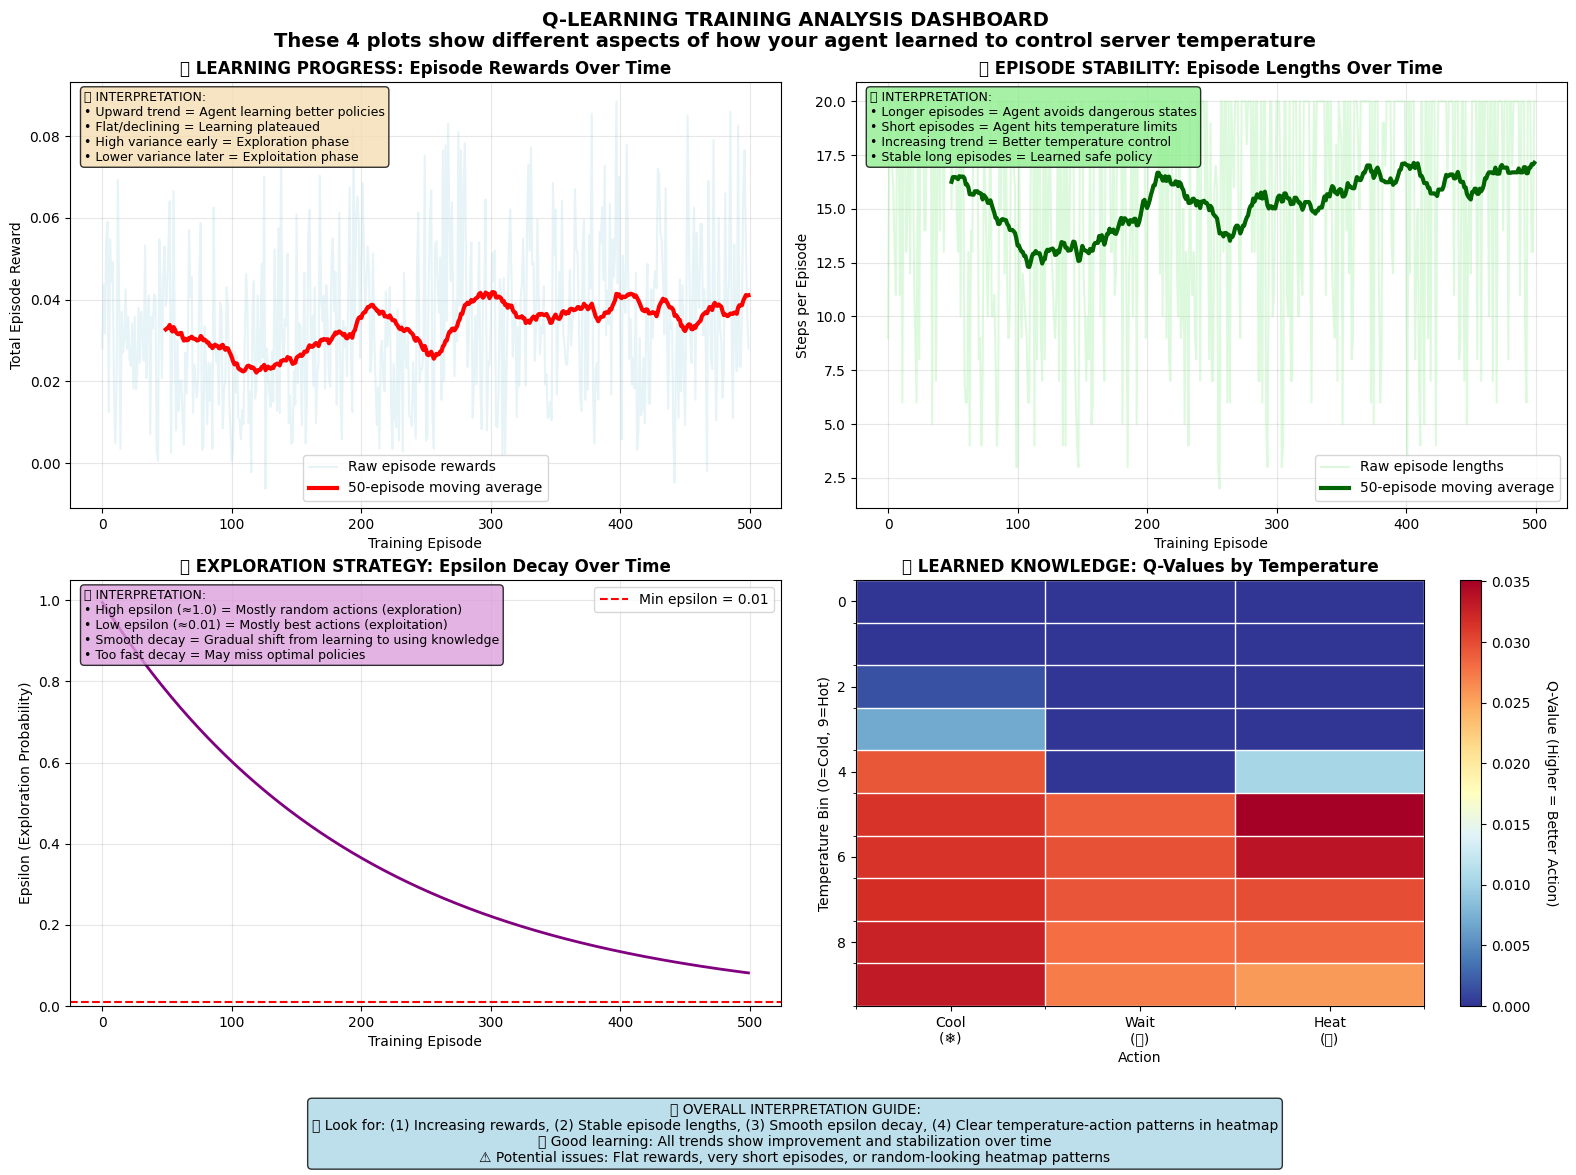


📊 NUMERICAL TRAINING SUMMARY
🎯 Learning Progress:
   • Early training avg reward (first 100 episodes): 0.0297
   • Late training avg reward (last 100 episodes): 0.0368
   • Overall improvement: +24.1%

⏱️ Episode Stability:
   • Average episode length: 15.4 steps
   • Longest episode: 20 steps
   • Shortest episode: 2 steps

🎯 Exploration Strategy:
   • Started with epsilon: 0.995
   • Ended with epsilon: 0.082
   • Total exploration reduction: 0.913

🧠 Knowledge Acquired:
   • Total states discovered: 10
   • Theoretical max states: 90
   • State space coverage: 11.1%

EDUCATIONAL SUMMARY

What just happened?
1. The agent started with no knowledge (random Q-values)
2. Through exploration, it discovered different states and rewards
3. The Q-learning equation updated beliefs about state-action values
4. Over time, exploration decreased and the agent exploited learned knowledge
5. The final policy shows what action to take in each temperature range

Key equation used:
Q(s,a) ← Q(s,a) + 

In [15]:
"""
Q-LEARNING ALGORITHM EXPLANATION
===============================

Q-Learning is a model-free reinforcement learning algorithm that learns the optimal
action-selection policy for any given finite Markov decision process (MDP).

KEY CONCEPTS:
-------------

1. Q-VALUE (Q(s,a)): The expected cumulative reward when taking action 'a' in state 's'
   and then following the optimal policy thereafter.

2. BELLMAN EQUATION: The fundamental equation that Q-learning is based on:
   Q*(s,a) = E[r + γ * max Q*(s',a') | s,a]

   Where:
   - Q*(s,a) = optimal Q-value for state s, action a
   - r = immediate reward
   - γ (gamma) = discount factor (0 ≤ γ ≤ 1)
   - s' = next state
   - max Q*(s',a') = maximum Q-value over all actions in next state

3. Q-LEARNING UPDATE EQUATION:
   Q(s,a) ← Q(s,a) + α[r + γ * max Q(s',a') - Q(s,a)]

   Where:
   - α (alpha) = learning rate (0 < α ≤ 1)
   - The term [r + γ * max Q(s',a') - Q(s,a)] is called the "temporal difference error"

4. EXPLORATION vs EXPLOITATION:
   - Exploration: Try random actions to discover new states/rewards
   - Exploitation: Use current knowledge to choose best known action
   - Epsilon-greedy: Choose random action with probability ε, best action with probability (1-ε)

5. CONVERGENCE:
   Under certain conditions (visiting all state-action pairs infinitely often and
   decreasing learning rate), Q-learning converges to the optimal Q-function Q*.

ALGORITHM STEPS:
---------------
1. Initialize Q-table with zeros (or random values)
2. For each episode:
   a. Start in initial state s
   b. For each step:
      - Choose action a using ε-greedy policy
      - Execute action a, observe reward r and next state s'
      - Update Q(s,a) using the update equation
      - Set s = s'
   c. Repeat until terminal state or max steps reached
3. Decay ε over time to reduce exploration

"""

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

class SimpleQLearning:
    """
    Simple Q-Learning agent for server temperature control

    This implementation uses:
    - Discrete state space (temperature bins)
    - Discrete action space (cool, do nothing, heat)
    - Q-table for value function approximation
    - Epsilon-greedy exploration strategy
    """

    def __init__(self, n_temperature_bins=10, learning_rate=0.1,
                 discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995,
                 min_epsilon=0.01):
        """
        Initialize Q-Learning agent

        Parameters:
        - n_temperature_bins: Number of discrete temperature states
        - learning_rate: How much to update Q-values (alpha)
        - discount_factor: Future reward discount (gamma)
        - epsilon: Initial exploration rate
        - epsilon_decay: How much to reduce epsilon each episode
        - min_epsilon: Minimum exploration rate
        """
        self.n_temperature_bins = n_temperature_bins
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Action space: 0=cool, 1=do nothing, 2=heat
        self.n_actions = 3
        self.action_map = {0: -1, 1: 0, 2: 1}  # Map to environment directions
        self.energy_per_action = {0: 2.0, 1: 0.0, 2: 2.0}  # Energy cost per action

        # Q-table: state -> action values
        self.q_table = defaultdict(lambda: np.zeros(self.n_actions))

        # Training statistics
        self.episode_rewards = []
        self.episode_lengths = []
        self.epsilon_history = []

    def discretize_state(self, continuous_state):
        """
        Convert continuous state to discrete state for Q-table lookup

        IMPROVED STATE REPRESENTATION:
        Instead of using only temperature, we'll use temperature + users + data_rate
        This creates a richer state space for better learning

        Parameters:
        - continuous_state: Normalized state from environment [temp, users, data_rate]

        Returns:
        - discrete_state: Tuple representing discretized state (temp_bin, user_bin, data_bin)
        """
        # Extract all three state variables (all normalized to [0,1])
        temperature = continuous_state[0, 0]
        users = continuous_state[0, 1]
        data_rate = continuous_state[0, 2]

        # Discretize temperature into bins
        temp_bin = int(temperature * self.n_temperature_bins)
        temp_bin = min(temp_bin, self.n_temperature_bins - 1)  # Ensure within bounds
        temp_bin = max(temp_bin, 0)  # Ensure not negative

        # Discretize users into 3 bins: low, medium, high
        user_bins = 3
        user_bin = int(users * user_bins)
        user_bin = min(user_bin, user_bins - 1)
        user_bin = max(user_bin, 0)

        # Discretize data rate into 3 bins: low, medium, high
        data_bins = 3
        data_bin = int(data_rate * data_bins)
        data_bin = min(data_bin, data_bins - 1)
        data_bin = max(data_bin, 0)

        # Create comprehensive state representation
        discrete_state = (temp_bin, user_bin, data_bin)

        return discrete_state

    def choose_action(self, state, verbose=False):
        """
        Choose action using epsilon-greedy strategy

        EPSILON-GREEDY EXPLANATION:
        - With probability ε (epsilon): choose RANDOM action (EXPLORATION)
        - With probability (1-ε): choose BEST action from Q-table (EXPLOITATION)

        This balances between:
        - Exploration: Discovering new states and better policies
        - Exploitation: Using current knowledge to maximize reward

        Parameters:
        - state: Current discrete state
        - verbose: Whether to print decision process

        Returns:
        - action: Chosen action (0=cool, 1=nothing, 2=heat)
        """
        if random.random() < self.epsilon:
            # EXPLORATION: Choose random action
            action = random.randint(0, self.n_actions - 1)
            if verbose:
                print(f"    Exploring: Random action {action} (ε={self.epsilon:.3f})")
        else:
            # EXPLOITATION: Choose best action from Q-table
            q_values = self.q_table[state]
            action = np.argmax(q_values)
            if verbose:
                print(f"    Exploiting: Best action {action}, Q-values={q_values}")

        return action

    def update_q_table(self, state, action, reward, next_state, done):
        """
        Update Q-table using Q-learning update rule

        *** THIS IS THE CORE OF Q-LEARNING ***

        The Q-learning update equation is:
        Q(s,a) ← Q(s,a) + α[r + γ * max Q(s',a') - Q(s,a)]

        Breaking it down:
        - Q(s,a): Current Q-value for state s, action a
        - α (alpha): Learning rate - how much we update (self.learning_rate)
        - r: Immediate reward received
        - γ (gamma): Discount factor for future rewards (self.discount_factor)
        - max Q(s',a'): Maximum Q-value for next state over all possible actions
        - [r + γ * max Q(s',a') - Q(s,a)]: Temporal Difference (TD) error

        Parameters:
        - state: Current state s
        - action: Action taken a
        - reward: Immediate reward r
        - next_state: Next state s'
        - done: Whether episode is finished (terminal state)
        """
        # Step 1: Get current Q-value Q(s,a)
        current_q = self.q_table[state][action]

        if done:
            # Terminal state: no future rewards, so target = immediate reward only
            target_q = reward
            print(f"    Terminal state reached. Target Q-value = {reward}")
        else:
            # Step 2: Calculate max Q(s',a') - maximum Q-value for next state
            max_next_q = np.max(self.q_table[next_state])

            # Step 3: Calculate target Q-value: r + γ * max Q(s',a')
            target_q = reward + self.discount_factor * max_next_q

            print(f"    Q-update: reward={reward:.4f}, γ*max_Q(s')={self.discount_factor*max_next_q:.4f}")

        # Step 4: Calculate temporal difference (TD) error
        td_error = target_q - current_q

        # Step 5: Apply Q-learning update equation
        # Q(s,a) ← Q(s,a) + α * TD_error
        self.q_table[state][action] = current_q + self.learning_rate * td_error

        print(f"    Q({state},{action}): {current_q:.4f} → {self.q_table[state][action]:.4f} (TD_error: {td_error:.4f})")

    def train(self, env, n_episodes=1000, max_steps_per_episode=50, verbose_frequency=100):
        """
        Train the Q-learning agent

        TRAINING PROCESS EXPLANATION:
        1. For each episode:
           a. Reset environment to initial state
           b. Choose action using ε-greedy policy
           c. Execute action and observe reward and next state
           d. Update Q-table using Q-learning equation
           e. Repeat until episode ends or max steps reached
        2. Decay ε to reduce exploration over time
        3. Track performance metrics

        Parameters:
        - env: Environment instance
        - n_episodes: Number of training episodes
        - max_steps_per_episode: Maximum steps per episode
        - verbose_frequency: How often to print detailed episode info
        """
        print(f"Starting Q-Learning training for {n_episodes} episodes...")
        print(f"Initial hyperparameters:")
        print(f"  Learning rate (α): {self.learning_rate}")
        print(f"  Discount factor (γ): {self.discount_factor}")
        print(f"  Initial exploration (ε): {self.epsilon}")
        print(f"  Epsilon decay: {self.epsilon_decay}")
        print(f"  Temperature bins: {self.n_temperature_bins}")
        print()

        for episode in range(n_episodes):
            # Reset environment for new episode
            month = episode % 12  # Cycle through months
            env.reset(new_month=month)

            # Get initial state
            continuous_state, _, _ = env.observe()
            state = self.discretize_state(continuous_state)

            episode_reward = 0
            step = 0

            # Verbose output for select episodes
            verbose = (episode + 1) % verbose_frequency == 0 or episode < 5

            if verbose:
                print(f"=== EPISODE {episode + 1} (Month {month + 1}) ===")
                print(f"Initial state: {state}, Initial temp: {continuous_state[0,0]:.3f}")

            for step in range(max_steps_per_episode):
                if verbose:
                    print(f"  Step {step + 1}:")

                # Choose action using ε-greedy policy
                action = self.choose_action(state, verbose=verbose)

                # Convert action to environment format
                direction = self.action_map[action]
                energy = self.energy_per_action[action]

                # Take action in environment
                if direction == 0:  # No action
                    # Just observe without taking action
                    next_continuous_state, reward, done = env.observe()
                    reward = 0  # No reward for doing nothing
                    if verbose:
                        print(f"    Action: Wait (no energy used)")
                else:
                    next_continuous_state, reward, done = env.update_env(
                        direction=direction,
                        energy_ai=energy,
                        month=(month + step) % 12
                    )
                    action_name = "Cool" if direction == -1 else "Heat"
                    if verbose:
                        print(f"    Action: {action_name} (energy: {energy})")

                # Convert to discrete state
                next_state = self.discretize_state(next_continuous_state)

                if verbose:
                    temp = (next_continuous_state[0,0] *
                           (env.max_temperature - env.min_temperature) +
                           env.min_temperature)
                    print(f"    Result: Temp={temp:.1f}°C, Reward={reward:.4f}, Next_state={next_state}")

                # *** CORE Q-LEARNING UPDATE ***
                if verbose:
                    print(f"    Q-Learning Update:")
                self.update_q_table(state, action, reward, next_state, done)

                # Update for next iteration
                state = next_state
                episode_reward += reward

                if done:
                    if verbose:
                        print(f"    Episode terminated early!")
                    break

            # Update exploration rate (epsilon decay)
            old_epsilon = self.epsilon
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

            # Store episode statistics
            self.episode_rewards.append(episode_reward)
            self.episode_lengths.append(step + 1)
            self.epsilon_history.append(self.epsilon)

            if verbose:
                print(f"Episode {episode + 1} Summary:")
                print(f"  Total reward: {episode_reward:.4f}")
                print(f"  Episode length: {step + 1} steps")
                print(f"  Epsilon: {old_epsilon:.3f} → {self.epsilon:.3f}")
                print(f"  Q-table size: {len(self.q_table)} states")
                print()

            # Print progress every 100 episodes
            elif (episode + 1) % 100 == 0:
                avg_reward = np.mean(self.episode_rewards[-100:])
                avg_length = np.mean(self.episode_lengths[-100:])
                print(f"Episode {episode + 1}: Avg Reward = {avg_reward:.4f}, "
                      f"Avg Length = {avg_length:.1f}, Epsilon = {self.epsilon:.3f}, "
                      f"Q-states = {len(self.q_table)}")

        print("Training completed!")
        print(f"Final Q-table contains {len(self.q_table)} state-action mappings")
        print(f"Final epsilon (exploration rate): {self.epsilon:.4f}")

        # Print some learned Q-values
        print("\nSample learned Q-values:")
        for i, (state, q_values) in enumerate(list(self.q_table.items())[:5]):
            best_action = np.argmax(q_values)
            action_names = ["Cool", "Wait", "Heat"]
            print(f"  State {state}: Q-values {q_values}, Best action: {action_names[best_action]}")
        print()

    def test(self, env, n_episodes=10, verbose=True):
        """
        Test the trained agent

        Parameters:
        - env: Environment instance
        - n_episodes: Number of test episodes
        - verbose: Whether to print detailed results
        """
        print(f"\nTesting trained agent for {n_episodes} episodes...")

        # Disable exploration for testing
        old_epsilon = self.epsilon
        self.epsilon = 0.0

        test_rewards = []
        test_lengths = []

        for episode in range(n_episodes):
            # Reset environment
            month = episode % 12
            env.reset(new_month=month)
            env.train = 0  # Set to inference mode

            # Get initial state
            continuous_state, _, _ = env.observe()
            state = self.discretize_state(continuous_state)

            episode_reward = 0
            step = 0

            if verbose:
                print(f"\nTest Episode {episode + 1} (Month {month + 1}):")

            for step in range(50):  # Max 50 steps per episode
                # Choose best action (no exploration)
                action = self.choose_action(state)

                # Convert to environment format
                direction = self.action_map[action]
                energy = self.energy_per_action[action]

                action_names = {0: "Cool", 1: "Wait", 2: "Heat"}

                if direction == 0:  # No action
                    next_continuous_state, reward, done = env.observe()
                    reward = 0
                else:
                    next_continuous_state, reward, done = env.update_env(
                        direction=direction,
                        energy_ai=energy,
                        month=(month + step) % 12
                    )

                if verbose:
                    temp_actual = (next_continuous_state[0,0] *
                                 (env.max_temperature - env.min_temperature) +
                                 env.min_temperature)
                    print(f"  Step {step + 1}: {action_names[action]}, "
                          f"Temp: {temp_actual:.1f}°C, Reward: {reward:.4f}")

                # Update for next iteration
                state = self.discretize_state(next_continuous_state)
                episode_reward += reward

                if done:
                    if verbose:
                        print(f"  Episode ended early at step {step + 1}")
                    break

            test_rewards.append(episode_reward)
            test_lengths.append(step + 1)

            if verbose:
                print(f"  Total reward: {episode_reward:.4f}")
                print(f"  AI energy used: {env.total_energy_ai:.2f}")
                print(f"  Baseline energy: {env.total_energy_noai:.2f}")

        # Restore original epsilon
        self.epsilon = old_epsilon

        print(f"\nTest Results:")
        print(f"Average reward: {np.mean(test_rewards):.4f}")
        print(f"Average episode length: {np.mean(test_lengths):.1f}")

        return test_rewards, test_lengths

    def plot_training_results(self):
        """
        Plot comprehensive training statistics with detailed explanations

        This function creates 4 plots that help understand the Q-learning process:
        1. Learning Progress (Episode Rewards)
        2. Episode Stability (Episode Lengths)
        3. Exploration Strategy (Epsilon Decay)
        4. Learned Knowledge (Q-Values Heatmap)
        """
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        window = 50  # Moving average window

        # ===== PLOT 1: EPISODE REWARDS =====
        # What it shows: How well the agent is performing over time
        # Learning indication: Upward trend means the agent is learning better policies

        axes[0, 0].plot(self.episode_rewards, alpha=0.3, color='lightblue',
                       label='Raw episode rewards')

        # Add moving average for clearer trend
        if len(self.episode_rewards) >= window:
            moving_avg = np.convolve(self.episode_rewards,
                                   np.ones(window)/window, mode='valid')
            axes[0, 0].plot(range(window-1, len(self.episode_rewards)),
                          moving_avg, color='red', linewidth=3,
                          label=f'{window}-episode moving average')

        axes[0, 0].set_title('📈 LEARNING PROGRESS: Episode Rewards Over Time',
                            fontsize=12, fontweight='bold')
        axes[0, 0].set_xlabel('Training Episode')
        axes[0, 0].set_ylabel('Total Episode Reward')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].legend()

        # Add explanation text
        axes[0, 0].text(0.02, 0.98,
            "📚 INTERPRETATION:\n" +
            "• Upward trend = Agent learning better policies\n" +
            "• Flat/declining = Learning plateaued\n" +
            "• High variance early = Exploration phase\n" +
            "• Lower variance later = Exploitation phase",
            transform=axes[0, 0].transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        # ===== PLOT 2: EPISODE LENGTHS =====
        # What it shows: How long episodes last (stability indicator)
        # Learning indication: Longer episodes mean agent avoids terminal states

        axes[0, 1].plot(self.episode_lengths, alpha=0.3, color='lightgreen',
                       label='Raw episode lengths')

        if len(self.episode_lengths) >= window:
            moving_avg = np.convolve(self.episode_lengths,
                                   np.ones(window)/window, mode='valid')
            axes[0, 1].plot(range(window-1, len(self.episode_lengths)),
                          moving_avg, color='darkgreen', linewidth=3,
                          label=f'{window}-episode moving average')

        axes[0, 1].set_title('⏱️ EPISODE STABILITY: Episode Lengths Over Time',
                            fontsize=12, fontweight='bold')
        axes[0, 1].set_xlabel('Training Episode')
        axes[0, 1].set_ylabel('Steps per Episode')
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].legend()

        # Add explanation text
        axes[0, 1].text(0.02, 0.98,
            "📚 INTERPRETATION:\n" +
            "• Longer episodes = Agent avoids dangerous states\n" +
            "• Short episodes = Agent hits temperature limits\n" +
            "• Increasing trend = Better temperature control\n" +
            "• Stable long episodes = Learned safe policy",
            transform=axes[0, 1].transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

        # ===== PLOT 3: EPSILON DECAY =====
        # What it shows: Exploration vs exploitation balance over time
        # Learning indication: Should decrease from 1.0 to min_epsilon

        axes[1, 0].plot(self.epsilon_history, color='purple', linewidth=2)
        axes[1, 0].axhline(y=self.min_epsilon, color='red', linestyle='--',
                          label=f'Min epsilon = {self.min_epsilon}')

        axes[1, 0].set_title('🎯 EXPLORATION STRATEGY: Epsilon Decay Over Time',
                            fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('Training Episode')
        axes[1, 0].set_ylabel('Epsilon (Exploration Probability)')
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].legend()
        axes[1, 0].set_ylim(0, 1.05)

        # Add explanation text
        axes[1, 0].text(0.02, 0.98,
            "📚 INTERPRETATION:\n" +
            "• High epsilon (≈1.0) = Mostly random actions (exploration)\n" +
            "• Low epsilon (≈0.01) = Mostly best actions (exploitation)\n" +
            "• Smooth decay = Gradual shift from learning to using knowledge\n" +
            "• Too fast decay = May miss optimal policies",
            transform=axes[1, 0].transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='plum', alpha=0.8))

        # ===== PLOT 4: Q-VALUES HEATMAP =====
        # What it shows: Learned action preferences for different temperatures
        # Learning indication: Clear patterns show the agent learned meaningful policies

        if len(self.q_table) > 0:
            # Create matrix for Q-values (average across user/data bins for each temp bin)
            q_matrix = np.zeros((self.n_temperature_bins, self.n_actions))
            temp_counts = np.zeros(self.n_temperature_bins)

            for state, actions in self.q_table.items():
                if len(state) == 3:  # Our 3D state representation (temp, users, data)
                    temp_bin = state[0]
                    if temp_bin < self.n_temperature_bins:
                        q_matrix[temp_bin] += actions
                        temp_counts[temp_bin] += 1

            # Average Q-values for each temperature bin
            for i in range(self.n_temperature_bins):
                if temp_counts[i] > 0:
                    q_matrix[i] /= temp_counts[i]

            # Create heatmap
            im = axes[1, 1].imshow(q_matrix, cmap='RdYlBu_r', aspect='auto',
                                  interpolation='nearest')
            axes[1, 1].set_title('🧠 LEARNED KNOWLEDGE: Q-Values by Temperature',
                                fontsize=12, fontweight='bold')
            axes[1, 1].set_xlabel('Action')
            axes[1, 1].set_ylabel('Temperature Bin (0=Cold, 9=Hot)')

            # Customize ticks and labels
            axes[1, 1].set_xticks([0, 1, 2])
            axes[1, 1].set_xticklabels(['Cool\n(❄️)', 'Wait\n(⏸️)', 'Heat\n(🔥)'])
            axes[1, 1].set_yticks(range(0, self.n_temperature_bins, 2))

            # Add colorbar with explanation
            cbar = plt.colorbar(im, ax=axes[1, 1])
            cbar.set_label('Q-Value (Higher = Better Action)', rotation=270, labelpad=20)

            # Add grid for better readability
            axes[1, 1].set_xticks(np.arange(-0.5, 3, 1), minor=True)
            axes[1, 1].set_yticks(np.arange(-0.5, self.n_temperature_bins, 1), minor=True)
            axes[1, 1].grid(which='minor', color='white', linestyle='-', linewidth=1)

        else:
            axes[1, 1].text(0.5, 0.5, 'No Q-values to display\n(Q-table is empty)',
                          ha='center', va='center', transform=axes[1, 1].transAxes,
                          fontsize=12, bbox=dict(boxstyle='round', facecolor='lightgray'))
            axes[1, 1].set_title('🧠 LEARNED KNOWLEDGE: Q-Values by Temperature')

        # Add overall explanation
        fig.suptitle('Q-LEARNING TRAINING ANALYSIS DASHBOARD\n' +
                    'These 4 plots show different aspects of how your agent learned to control server temperature',
                    fontsize=14, fontweight='bold', y=0.98)

        # Add interpretation guide at the bottom
        fig.text(0.5, 0.02,
            "💡 OVERALL INTERPRETATION GUIDE:\n" +
            "🔍 Look for: (1) Increasing rewards, (2) Stable episode lengths, (3) Smooth epsilon decay, (4) Clear temperature-action patterns in heatmap\n" +
            "✅ Good learning: All trends show improvement and stabilization over time\n" +
            "⚠️ Potential issues: Flat rewards, very short episodes, or random-looking heatmap patterns",
            ha='center', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

        plt.tight_layout()
        plt.subplots_adjust(top=0.92, bottom=0.15)  # Make room for title and footer
        plt.show()

        # Print numerical summary
        print("\n" + "="*70)
        print("📊 NUMERICAL TRAINING SUMMARY")
        print("="*70)

        if len(self.episode_rewards) >= 100:
            early_avg = np.mean(self.episode_rewards[:100])
            late_avg = np.mean(self.episode_rewards[-100:])
            improvement = ((late_avg - early_avg) / abs(early_avg)) * 100 if early_avg != 0 else 0

            print(f"🎯 Learning Progress:")
            print(f"   • Early training avg reward (first 100 episodes): {early_avg:.4f}")
            print(f"   • Late training avg reward (last 100 episodes): {late_avg:.4f}")
            print(f"   • Overall improvement: {improvement:+.1f}%")

        print(f"\n⏱️ Episode Stability:")
        print(f"   • Average episode length: {np.mean(self.episode_lengths):.1f} steps")
        print(f"   • Longest episode: {max(self.episode_lengths)} steps")
        print(f"   • Shortest episode: {min(self.episode_lengths)} steps")

        print(f"\n🎯 Exploration Strategy:")
        print(f"   • Started with epsilon: {self.epsilon_history[0]:.3f}")
        print(f"   • Ended with epsilon: {self.epsilon_history[-1]:.3f}")
        print(f"   • Total exploration reduction: {(self.epsilon_history[0] - self.epsilon_history[-1]):.3f}")

        print(f"\n🧠 Knowledge Acquired:")
        print(f"   • Total states discovered: {len(self.q_table)}")
        print(f"   • Theoretical max states: {self.n_temperature_bins * 3 * 3}")
        coverage = (len(self.q_table) / (self.n_temperature_bins * 3 * 3)) * 100
        print(f"   • State space coverage: {coverage:.1f}%")
        print("="*70)

# Example usage and demonstration
if __name__ == "__main__":
    print("="*80)
    print("Q-LEARNING TUTORIAL: Server Temperature Control")
    print("="*80)
    print()
    print("This demonstration shows Q-Learning in action!")
    print("The agent learns to control server temperature efficiently.")
    print()
    print("KEY LEARNING OBJECTIVES:")
    print("1. Understand the Q-learning update equation")
    print("2. See exploration vs exploitation in action")
    print("3. Observe how Q-values converge over training")
    print("4. Compare AI performance vs baseline system")
    print()

    # Create environment
    env = Environment(
        optimal_temperature=[20.0, 25.0],
        initial_month=0,
        initial_number_users=10,
        initial_rate_data=20
    )

    print("Environment created with:")
    print(f"  Optimal temperature range: {env.optimal_temperature}°C")
    print(f"  Temperature limits: {env.min_temperature}°C to {env.max_temperature}°C")
    print(f"  Starting conditions: {env.initial_number_users} users, {env.initial_rate_data} data rate")
    print()

    # Create Q-learning agent
    agent = SimpleQLearning(
        n_temperature_bins=10,        # Discretize temperature into 10 bins
        learning_rate=0.1,            # α = 0.1 (moderate learning)
        discount_factor=0.95,         # γ = 0.95 (value future rewards highly)
        epsilon=1.0,                  # Start with 100% exploration
        epsilon_decay=0.995,          # Gradually reduce exploration
        min_epsilon=0.01              # Always keep 1% exploration
    )

    print("Q-Learning agent created!")
    print("Watch the learning process in the first few episodes...")
    print()

    # Train the agent with detailed output for first few episodes
    agent.train(env, n_episodes=500, max_steps_per_episode=20, verbose_frequency=100)

    print("\n" + "="*60)
    print("TRAINING ANALYSIS")
    print("="*60)

    # Analyze final Q-table
    total_states = len(agent.q_table)
    print(f"Total states discovered: {total_states}")
    print(f"Average episode reward (last 100): {np.mean(agent.episode_rewards[-100:]):.4f}")
    print(f"Final exploration rate: {agent.epsilon:.4f}")

    print("\nLEARNED POLICY ANALYSIS:")
    action_names = ["Cool", "Wait", "Heat"]

    # Group states by temperature bin and show most common actions
    temp_policies = {}
    for temp_bin in range(agent.n_temperature_bins):
        temp_policies[temp_bin] = []

    for state, q_values in agent.q_table.items():
        if len(state) == 3:  # (temp_bin, user_bin, data_bin)
            temp_bin = state[0]
            best_action = np.argmax(q_values)
            temp_policies[temp_bin].append(best_action)

    print("Best actions by temperature range:")
    for temp_bin in range(agent.n_temperature_bins):
        if temp_policies[temp_bin]:
            # Find most common action for this temperature
            actions = temp_policies[temp_bin]
            most_common = max(set(actions), key=actions.count)
            temp_range_low = temp_bin / agent.n_temperature_bins
            temp_range_high = (temp_bin + 1) / agent.n_temperature_bins

            # Convert back to actual temperature
            actual_temp_low = temp_range_low * (env.max_temperature - env.min_temperature) + env.min_temperature
            actual_temp_high = temp_range_high * (env.max_temperature - env.min_temperature) + env.min_temperature

            print(f"  Temp {actual_temp_low:.1f}-{actual_temp_high:.1f}°C: {action_names[most_common]} "
                  f"(from {len(actions)} state-action pairs)")
        else:
            print(f"  Temperature bin {temp_bin}: No data")

    # Show sample of actual states discovered
    print(f"\nSample of discovered states (showing first 10 of {total_states}):")
    for i, (state, q_values) in enumerate(list(agent.q_table.items())[:10]):
        best_action = np.argmax(q_values)
        if len(state) == 3:
            temp_bin, user_bin, data_bin = state
            print(f"  State (T:{temp_bin}, U:{user_bin}, D:{data_bin}): "
                  f"{action_names[best_action]} (Q-values: {q_values.round(3)})")
        else:
            print(f"  State {state}: {action_names[best_action]} (Q-values: {q_values.round(3)})")

    if total_states > 10:
        print(f"  ... and {total_states - 10} more states")

    print("\n" + "="*60)
    print("TESTING PHASE")
    print("="*60)

    # Test the agent
    test_rewards, test_lengths = agent.test(env, n_episodes=3, verbose=True)

    # Plot results
    print("\nGenerating training analysis plots...")
    agent.plot_training_results()

    print("\n" + "="*60)
    print("EDUCATIONAL SUMMARY")
    print("="*60)
    print()
    print("What just happened?")
    print("1. The agent started with no knowledge (random Q-values)")
    print("2. Through exploration, it discovered different states and rewards")
    print("3. The Q-learning equation updated beliefs about state-action values")
    print("4. Over time, exploration decreased and the agent exploited learned knowledge")
    print("5. The final policy shows what action to take in each temperature range")
    print()
    print("Key equation used:")
    print("Q(s,a) ← Q(s,a) + α[r + γ * max Q(s',a') - Q(s,a)]")
    print()
    print("Try modifying the hyperparameters and see how it affects learning!")

    print("\nQ-Learning demonstration completed!")
    print(f"Final Q-table size: {len(agent.q_table)} states")

In [13]:
test_rewards, test_lengths = agent.test(env, n_episodes=3, verbose=True)


Testing trained agent for 3 episodes...

Test Episode 1 (Month 1):
  Step 1: Cool, Temp: 44.0°C, Reward: -0.0020
  Step 2: Cool, Temp: 41.0°C, Reward: 0.0005
  Step 3: Cool, Temp: 46.0°C, Reward: -0.0010
  Step 4: Cool, Temp: 55.8°C, Reward: 0.0000
  Step 5: Cool, Temp: 58.5°C, Reward: 0.0097
  Step 6: Cool, Temp: 53.0°C, Reward: 0.0027
  Step 7: Cool, Temp: 55.2°C, Reward: -0.0020
  Step 8: Cool, Temp: 56.8°C, Reward: -0.0013
  Step 9: Cool, Temp: 46.5°C, Reward: 0.0015
  Step 10: Cool, Temp: 37.5°C, Reward: 0.0013
  Step 11: Heat, Temp: 44.5°C, Reward: 0.0050
  Step 12: Cool, Temp: 51.0°C, Reward: -0.0020
  Step 13: Cool, Temp: 46.5°C, Reward: 0.0065
  Step 14: Cool, Temp: 49.8°C, Reward: -0.0020
  Step 15: Cool, Temp: 38.5°C, Reward: 0.0008
  Step 16: Heat, Temp: 58.5°C, Reward: 0.0023
  Step 17: Cool, Temp: 71.2°C, Reward: 0.0110
  Step 18: Cool, Temp: 73.2°C, Reward: 0.0128
  Step 19: Cool, Temp: 58.0°C, Reward: 0.0020
  Step 20: Cool, Temp: 64.5°C, Reward: 0.0063
  Step 21: Cool